# Feature Detection

Given a target image with a feature and an input image, try to identify all locations of the target in the input. 

In [1]:
import numpy as np

import cv2
from PIL import Image

from scipy.signal import fftconvolve

import os

import matplotlib.pyplot as plt
%matplotlib inline

## OpenCV Implementation

In [2]:
def detect_features_opencv(target_image_path, template_path, number = 'one', threshold=0.75):
    
    
    method = eval('cv2.TM_SQDIFF')
    
    if number == 'one':
        target = cv2.imread(target_image_path, 0)
        template = cv2.imread(template_path, 0)
        h, w = template.shape
        res = cv2.matchTemplate(target, template, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)


        top_left = min_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(target, top_left, bottom_right, 255, 2)

        plt.figure(figsize=(16, 16))
        plt.subplot(121); plt.imshow(res, cmap='gray')
        plt.title('Match'); plt.axis('off')
        plt.subplot(122); plt.imshow(target, cmap='gray')
        plt.title('Detection'); plt.axis('off')
        plt.show();
        
    elif number == 'many':
        target_rgb = cv2.imread(target_image_path)
        target_gray = cv2.cvtColor(target_rgb, cv2.COLOR_BGR2GRAY)
        template = cv2.imread(template_path, 0)
        
        method = eval('cv2.TM_CCOEFF_NORMED')
        h , w = template.shape
        
        res = cv2.matchTemplate(target_gray, template, method)
        loc = np.where(res >= threshold)
        
        for point in zip(*loc[::-1]):
            cv2.rectangle(target_rgb, point, (point[0] + w, point[1] + h), (0, 0, 255), 2)
            
        cv2.imwrite('result.png', target_rgb)
        result = plt.imread('result.png')
        plt.figure(figsize=(12, 12))
        plt.imshow(result); plt.axis('off');
        plt.title('Detection Results', size = 24);
        plt.show();
    
        os.remove('result.png')
    else:
        print('Enter Valid Number (one or many)')

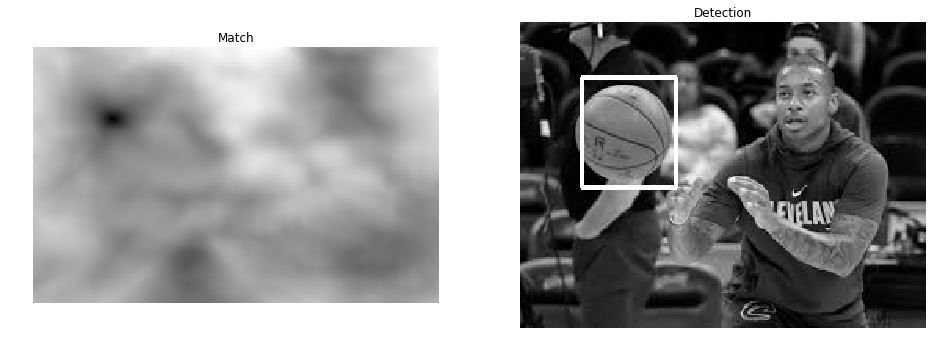

In [3]:
detect_features_opencv('images/target.jpg', 'images/template.jpg')

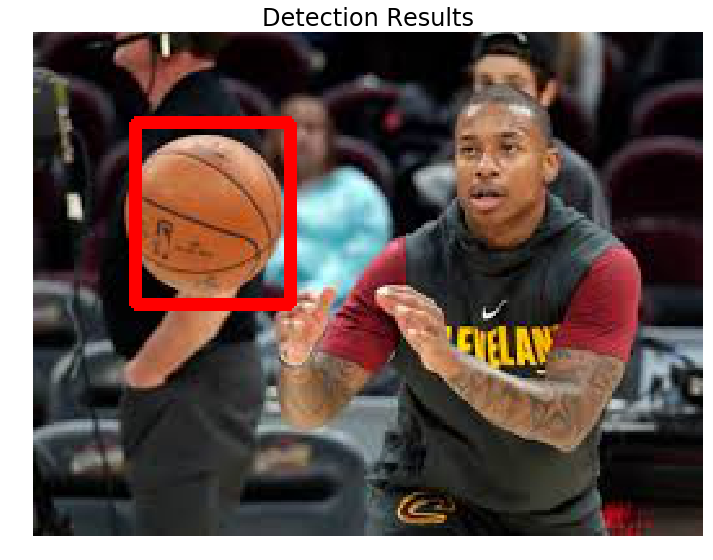

In [4]:
detect_features_opencv('images/target.jpg', 'images/template.jpg', number = 'many', threshold=0.9)

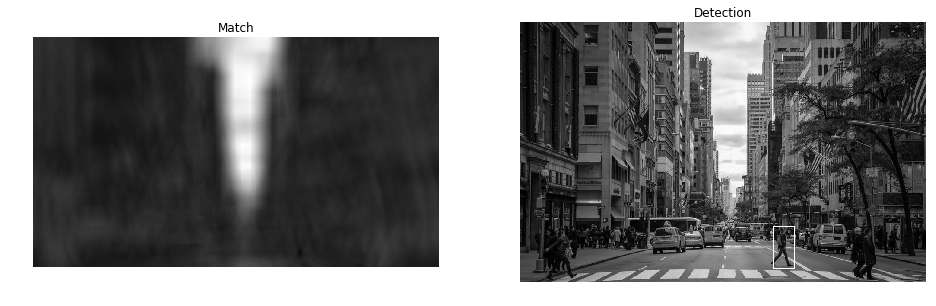

In [5]:
detect_features_opencv('images/target_street.jpg', 'images/template_human.jpg')

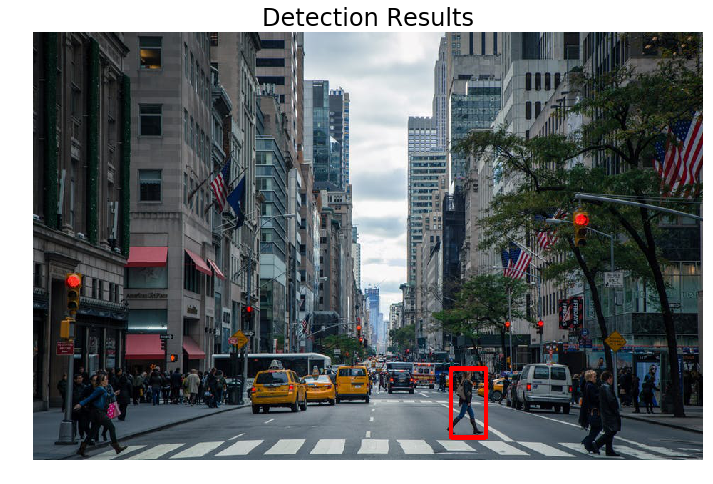

In [6]:
detect_features_opencv('images/target_street.jpg', 'images/template_human.jpg',
                number = 'many', threshold=0.75)

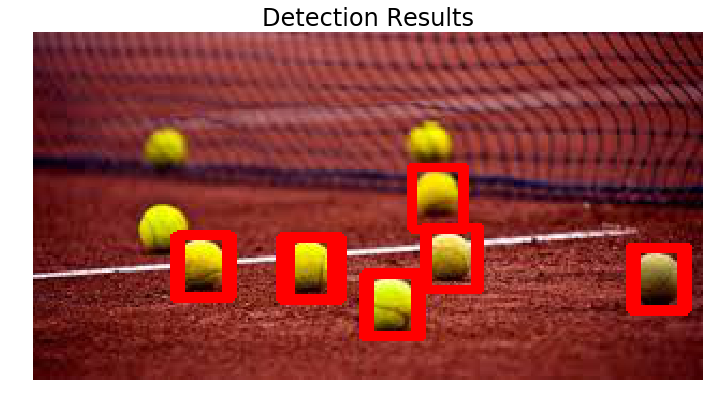

In [7]:
detect_features_opencv('images/target_tennis.jpg', 'images/template_tennis.jpg',
               number = 'many', threshold = 0.8)

## Implementation by Hand

Using Fast Fourier Transform Convolution. 

In [8]:
def _window_sum_2d(image, window_shape):
    window_sum = np.cumsum(image, axis=0)
    window_sum = (window_sum[window_shape[0]:-1] - 
                 window_sum[:-window_shape[0] - 1])
    
    window_sum = np.cumsum(window_sum, axis=1)
    window_sum = (window_sum[:, window_shape[1]:-1] -
                 window_sum[:, :-window_shape[1] - 1])
    
    return window_sum

In [9]:
def _window_sum_3d(image, window_shape):
    window_sum = _window_sum_2d(image, window_shape)
    
    window_sum = np.cumsum(window_sum, axis=2)
    window_sum = (window_sum[:, :, window_shape[2]:-1] - 
                  window_sum[:, :, :-window_shape[2] - 1])
    
    return window_sum

In [10]:
def detect_features(image_path, template_path, pad_input=True, mode='constant', constant_value=0):
    
    image = Image.open(image_path)
    image = np.array(image, dtype=np.float64, copy=False)

    orig_image = image.copy().astype(np.uint8)
    
    template = Image.open(template_path)
    template = np.array(template)
    
    if image.ndim < template.ndim:
        raise ValueError("Dimensionaliy of template must be less than or equal"
                         " to the dimensionality of image.")
    if np.any(np.less(image.shape, template.shape)):
        raise ValueError("Image must be larger than templtate")
        
    image_shape = image.shape
    
    pad_width = tuple((width, width) for width in template.shape)
    
    if mode == 'constant':
        image = np.pad(image, pad_width=pad_width, mode=mode,
                      constant_values=constant_value)
    else:
        image = np.pad(image, pad_width=pad_width, mode=mode)
        
    if image.ndim == 2:
        image_window_sum = _window_sum_2d(image, template.shape)
        image_window_sum2 = _window_sum_2d(image ** 2, template.shape)
        
    elif image.ndim == 3:
        image_window_sum = _window_sum_3d(image, template.shape)
        image_window_sum2 = _window_sum_3d(image ** 2, template.shape)
        
    template_mean = template.mean()
    template_volume = np.prod(template.shape)
    template_ssd = np.sum((template - template_mean) ** 2)
    
    if image.ndim == 2:
        xcorr = fftconvolve(image, template[::-1, ::-1],
                           mode='valid')[1:-1, 1:-1]
    elif image.ndim == 3:
        xcorr = fftconvolve(image, template[::-1, ::-1, ::-1],
                           mode = 'valid')[1:-1, 1:-1, 1:-1]
        
    # Normalization
    numerator = xcorr - image_window_sum * template_mean
    denominator = image_window_sum2
    np.multiply(image_window_sum, image_window_sum, out=image_window_sum)
    np.divide(image_window_sum, template_volume, out=image_window_sum)
    denominator = denominator - image_window_sum
    denominator = denominator * template_ssd
    np.maximum(denominator, 0, out=denominator)
    np.sqrt(denominator, out=denominator)
    
    response = np.zeros_like(xcorr, dtype=np.float64)
    
    mask = denominator > np.finfo(np.float64).eps
    
    response[mask] = numerator[mask] / denominator[mask]
    
    slices = []
    
    for i in range(template.ndim):
        if pad_input:
            d0 = (template.shape[i] - 1) // 2
            d1 = d0 + image_shape[i]
        else:
            d0 = template.shape[i] - 1
            d1 = d0 + image_shape[i] - template.shape[i] + 1
        slices.append(slice(d0, d1))
    
    return orig_image, template, response[slices]
        

In [50]:
image, template, response = detect_features(image_path='images/target.jpg', template_path='images/template.jpg')

In [51]:
pos = np.array((np.where(response[:, :, :] > 0.8)))

In [55]:
response.shape

(195, 259, 3)

In [61]:
x, y, z = pos[:, 0]

In [62]:
response[x, y, z]

0.83141218729608279

In [69]:
positions = []
for position in range(pos.shape[1]):
    x, y, z = pos[:, position]
    value = response[x, y, z]
    positions.append((x, y, z, value))
    
sorted(positions, key = lambda x: x[3], reverse = True)

In [177]:
def model(image_path, template_path, number = 'many', threshold = 0.8):
    
    image, template, response = detect_features(image_path, template_path, 
                                               pad_input=True)
    
    

    plt.figure(figsize=(2, 2))
    ax1 = plt.subplot(1, 1, 1)
    ax1.imshow(template)
    ax1.set_axis_off()
    ax1.set_title('Template', size = 20)
    plt.show()
    
    fig = plt.figure(figsize=(20, 16))
    ax2 = plt.subplot(1, 2, 1, adjustable = 'box-forced')
    ax3 = plt.subplot(1, 2, 2, sharex=ax2, sharey=ax2, adjustable = 'box-forced')

    ax2.imshow(image)
    ax2.set_axis_off()
    ax2.set_title('Target Image', size = 20)
    
    
    htemplate, wtemplate = template.shape[:2]
    
    if number == 'many':
        detections = 0
        
        pos = np.array(np.where(response[:, :, :] > threshold))
        
        recorded_boxes = [] 
        
        
        positions = []
        for position in range(pos.shape[1]):
            x, y, z = pos[:, position]
            value = response[x, y, z]
            positions.append((x, y, z, value))
            
        positions = sorted(positions, key = lambda x: x[3], reverse = True)
        
        for entry in positions:

            y, x = entry[:2]
            
            record = False
            
            for box in recorded_boxes:
                
                left, right, bottom, top = box
                
                if (x > left) & (x < right) & (y > bottom) & (y < top):
                    record = True
            
            if not record:
                rank = detections
                
                # left, right, bottom, top
                bounding_box = (x - wtemplate / 2, x + wtemplate / 2, 
                                y - htemplate / 2, y + htemplate / 2)

                recorded_boxes.append(bounding_box)

                rect = plt.Rectangle((x - wtemplate / 2, y - htemplate / 2), 
                                 wtemplate, htemplate, edgecolor='r', facecolor='none', lw = 4)
                ax2.add_patch(rect)

                
                # circle = plt.Circle((x, y), radius = 6,  edgecolor='r', facecolor='none', lw = 4)
                ax3.plot(x,  y, marker = '$%d$' % (rank + 1), ms = 32, color = 'k')
                
                detections += 1
        
        print('{} detections with threshold: {}\n'.format(detections, threshold))
    
    elif number == 'one':
        ij = np.unravel_index(np.argmax(response), response.shape)

        y, x = ij[:2]

        rect = plt.Rectangle((x - wtemplate / 2, y - htemplate / 2), 
                             wtemplate, htemplate, edgecolor='r', facecolor='none', lw = 4)
        ax2.add_patch(rect)
        circle = plt.Circle((x, y), radius = 6,  edgecolor='r', facecolor='none', lw = 4)
        ax3.add_patch(circle)
    
    response = (response * 255).astype(np.uint8)
    ax3.imshow(response)
    ax3.set_axis_off()
    ax3.set_title('Response from Feature Detection', size = 20)
    ax3.autoscale(False)

    plt.show()

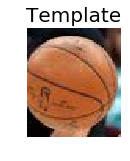

1 detections with threshold: 0.5



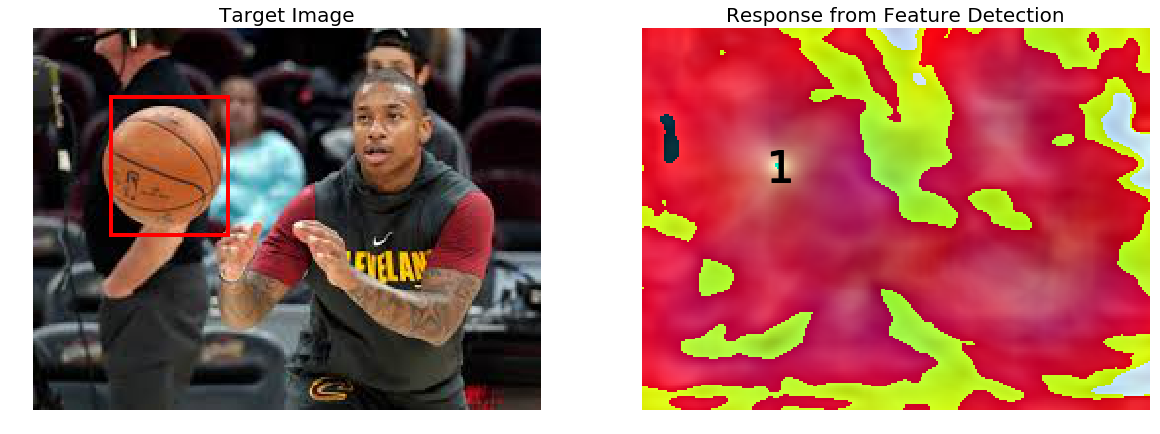

In [178]:
model(image_path='images/target.jpg', template_path='images/template.jpg', threshold=0.5)

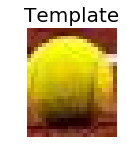

6 detections with threshold: 0.85



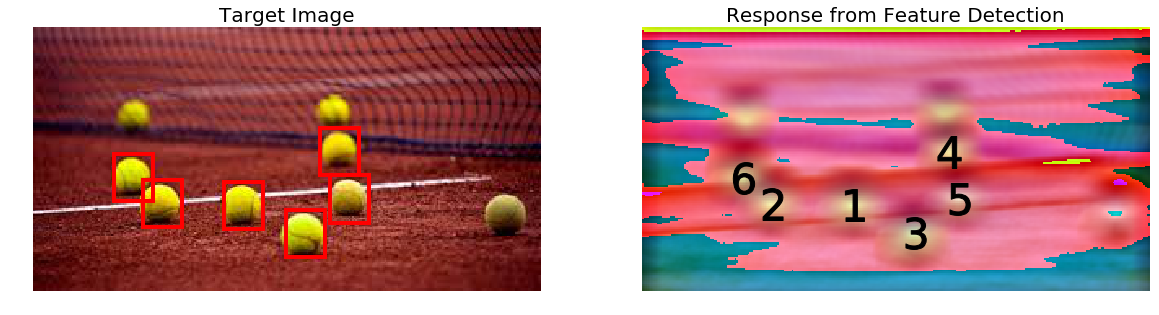

In [181]:
model(image_path = 'images/target_tennis.jpg', template_path = 'images/template_tennis.jpg', threshold=0.85)

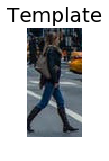

1 detections with threshold: 0.9



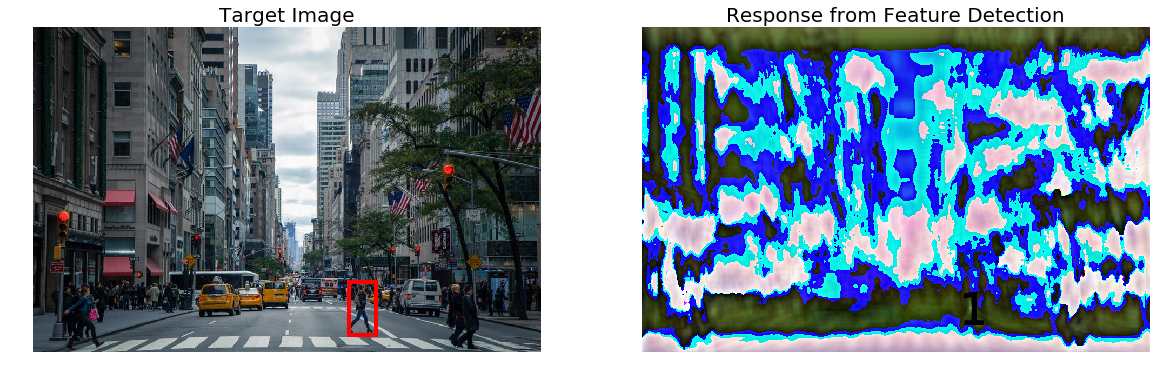

In [182]:
model(image_path = 'images/target_street.jpg', template_path = 'images/template_human.jpg', threshold=0.9)